In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
segments = pd.read_csv("../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUTS/merged_segments_1000M.csv")
gps_data = pd.read_csv("../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUTS/merged_gps_data_1000M.csv")

In [3]:
segments.dropna(inplace=True)

In [4]:
segments

,segment_id,road_section_id,segment_starting_time,segment_ending_time,trip_id,deviceid,date,start_terminal,end_terminal,direction,...,eleXspeed_count_n,average_acceleration,average_deacceleration,std_acc_dacc,max_acceleration,max_deacceleration,no_data_points,no_acc_points,no_deacc_points,stop_count
0,1,-17,2021-10-16 07:08:31,2021-10-16 07:09:49,1.0,116,2021-10-16,BT02,BT01,2,...,5,0.611952,-3.419728,1.622765,0.827937,-3.419728,6,1,1,0
1,2,-16,2021-10-16 07:09:49,2021-10-16 07:12:11,1.0,116,2021-10-16,BT02,BT01,2,...,6,0.417567,-0.395969,0.420138,1.079913,-0.431965,10,2,2,1
2,3,-15,2021-10-16 07:12:11,2021-10-16 07:13:41,1.0,116,2021-10-16,BT02,BT01,2,...,4,0.557956,-0.071993,0.299448,0.827933,-0.071993,6,1,1,0
3,4,-14,2021-10-16 07:13:41,2021-10-16 07:16:59,1.0,116,2021-10-16,BT02,BT01,2,...,4,0.818936,-1.136995,0.976509,1.394892,-2.314100,14,5,5,2
4,5,-13,2021-10-16 07:16:59,2021-10-16 07:21:42,1.0,116,2021-10-16,BT02,BT01,2,...,9,0.259980,-0.783629,0.457601,0.467963,-1.370658,19,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287397,287398,-5,2022-11-01 18:22:21,2022-11-01 18:24:36,17196.0,1377,2022-11-01,BT02,BT01,2,...,3,0.125990,-0.143988,0.137588,0.179987,-0.251977,9,6,6,0
287398,287399,-4,2022-11-01 18:24:36,2022-11-01 18:26:04,17196.0,1377,2022-11-01,BT02,BT01,2,...,2,0.563030,-0.557953,0.712270,1.329123,-0.827933,6,2,2,1
287399,287400,-3,2022-11-01 18:26:04,2022-11-01 18:29:10,17196.0,1377,2022-11-01,BT02,BT01,2,...,8,0.388770,-0.426824,0.508325,0.971920,-0.899932,13,7,7,1
287400,287401,-2,2022-11-01 18:29:10,2022-11-01 18:31:40,17196.0,1377,2022-11-01,BT02,BT01,2,...,4,0.179988,-0.136790,0.200384,0.395971,-0.359971,10,5,5,0


In [5]:
norms_list = []
for rs_id in segments['road_section_id'].unique():
    temp_segments = segments[segments['road_section_id'] == rs_id]
    # FIXME - make sure how mean is calculated (With or without zero values)
    row = {
        "road_section_id": rs_id,
        "speed_mean": (temp_segments['speed_mean'] * temp_segments['no_data_points']).sum() / (temp_segments['no_data_points'].sum()),
        "speed_std": math.sqrt(((temp_segments['speed_std']**2) * (temp_segments['no_data_points']-1)).sum() / (temp_segments['no_data_points']-1).sum()),
        "ele_X_speed_p": (temp_segments['ele_X_speed_p'] * (temp_segments['no_data_points']-1)).sum() / (temp_segments['no_data_points']-1).sum(),
        "ele_X_speed_n": (temp_segments['ele_X_speed_n'] * (temp_segments['no_data_points']-1)).sum() / (temp_segments['no_data_points']-1).sum(),
        "average_acceleration": (temp_segments['average_acceleration'] * temp_segments['no_acc_points']).sum() / temp_segments['no_acc_points'].sum(),
        "average_deacceleration": (temp_segments['average_deacceleration'] * temp_segments['no_deacc_points']).sum() / temp_segments['no_deacc_points'].sum(),
        "std_acc_dacc": math.sqrt(((temp_segments['std_acc_dacc']**2) * (temp_segments['no_acc_points'] + temp_segments['no_deacc_points'] -1)).sum() / (temp_segments['no_acc_points'] + temp_segments['no_deacc_points'] -1).sum()),
    }
    norms_list.append(row)

In [6]:
norms_df = pd.DataFrame(norms_list)
norms_df = norms_df.set_index('road_section_id')
norms_df.dropna(inplace=True)

In [7]:
important_cols = ['speed_mean', 'speed_std', 'ele_X_speed_p', 'ele_X_speed_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc']
segments_wrt_norms = []
for ind, row in segments.iterrows():
    data = {
        'segment_id': row['segment_id'],
        'road_section_id': row['road_section_id']
    }
    for col in important_cols:
        data[col] = row[col] - norms_df.loc[row['road_section_id'],col]
    segments_wrt_norms.append(data)

In [8]:
wrt_norms_df = pd.DataFrame(segments_wrt_norms)

In [24]:
no_pca_components = 4
no_clusters = 3

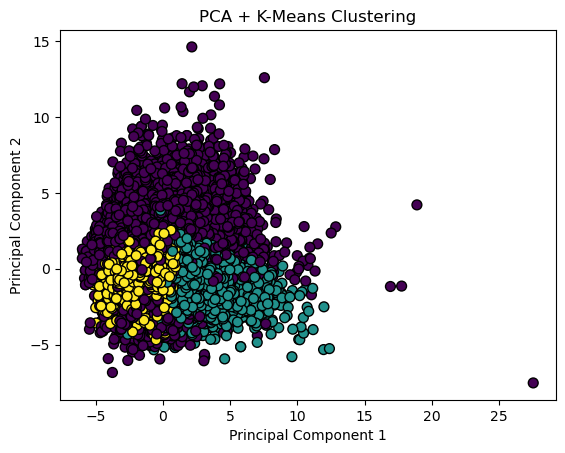

In [25]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = wrt_norms_df.drop(columns=["segment_id", "road_section_id"])

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=no_pca_components)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Fit Gaussian Mixture Model
n_components = no_clusters  # Number of clusters/components
gmm = GaussianMixture(n_components=n_components)
principal_df['cluster'] = gmm.fit_predict(principal_components)


X['PC1'] = principal_df['PC1']
X['PC2'] = principal_df['PC2']
X['PC3'] = principal_df['PC3']
X['PC4'] = principal_df['PC4']

# Plot the clusters in the reduced space
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Assuming 'data' is your DataFrame
# data.to_csv('kmeans_clusters.csv', index=False)

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Calculate silhouette score
score_silhouette = silhouette_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

# calculate davies bouldin score
db_index = davies_bouldin_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

print("Silhouette Score: ", score_silhouette)
print("Davies Bouldin Index: ", db_index)
print("Calinski-Harabasz Index:", ch_index)


Silhouette Score:  0.22472218721107903
Davies Bouldin Index:  2.1674686371314187
Calinski-Harabasz Index: 48474.95382084151


In [27]:
eval_clustering = {
    "no_pca_components": no_pca_components,
    "no_of_clusters": no_clusters,
    "explained_variance_ratio": sum(pca.explained_variance_ratio_),
    "silhouette Score": score_silhouette,
    "Davies Bouldin Index": db_index,
    "Calinski-Harabasz Index": ch_index
}

In [29]:
eval_clustering

{'no_pca_components': 4,
 'no_of_clusters': 3,
 'explained_variance_ratio': 0.8437374668269161,
 'silhouette Score': 0.22472218721107903,
 'Davies Bouldin Index': 2.1674686371314187,
 'Calinski-Harabasz Index': 48474.95382084151}

In [68]:
out_segments = segments
out_segments['cluster'] = X['cluster']
out_segments.to_csv("norms-clustering-results-original-f.csv", index=False)

In [64]:
out_wrt_norms_df = wrt_norms_df

In [65]:
out_wrt_norms_df['cluster'] = X['cluster']
out_wrt_norms_df.to_csv("norms-clustering-results.csv", index=False)

In [66]:
out_wrt_norms_df.columns

Index(['segment_id', 'road_section_id', 'speed_mean', 'speed_std',
       'ele_X_speed_p', 'ele_X_speed_n', 'average_acceleration',
       'average_deacceleration', 'std_acc_dacc', 'cluster'],
      dtype='object')

In [46]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)
sum(pca.explained_variance_ratio_)

0.7362076716052925

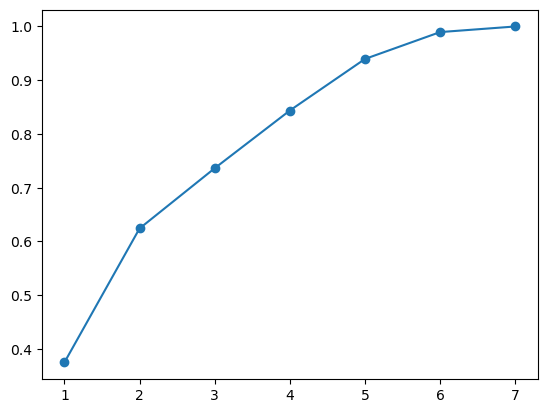

In [47]:
variances = []
for i in range(1,8):
    pca = PCA(n_components=i)
    principal_components = pca.fit_transform(X_scaled)
    variances.append(sum(pca.explained_variance_ratio_))
plt.plot([i for i in range(1,8)], variances, marker='o', linestyle='-')

In [34]:
wrt_norms_df.dropna(subset=["segment_id", "road_section_id"])

,segment_id,road_section_id,speed_mean,speed_std,ele_X_speed_p,ele_X_speed_n,average_acceleration,average_deacceleration,std_acc_dacc
0,1,-17,4.552251,2.231322,-0.225982,0.261660,0.002672,-2.517016,0.601170
1,2,-16,8.514276,4.375066,0.442069,0.524689,-0.237835,0.925227,-0.901021
2,3,-15,8.051022,4.416867,0.319807,0.023696,-0.111177,1.303846,-1.052945
3,4,-14,3.714884,2.740994,0.096845,0.047760,0.276011,0.198635,-0.298248
4,5,-13,-2.288808,-0.116908,-0.112457,-0.119490,-0.389730,0.785423,-0.998250
...,...,...,...,...,...,...,...,...,...
287397,287398,-5,0.337722,-2.942751,-0.249861,-0.101105,-0.480561,0.999486,-1.118823
287398,287399,-4,2.607345,-0.495085,0.161530,-0.449819,-0.082960,0.632701,-0.585609
287399,287400,-3,1.987255,0.087431,0.033870,0.057833,-0.266641,0.556344,-0.610349
287400,287401,-2,2.414085,-1.988776,-0.019092,-0.081388,-0.388412,0.598482,-0.724494


In [3]:
merged = pd.merge(segments,gps_data, on="segment_id", how='inner')
needed = merged[['road_section_id','speed']]
df = needed.groupby('road_section_id').mean()
df.rename(columns={"speed":"speed_mean"}, inplace=True)
df['speed_std'] = needed.groupby('road_section_id').std()['speed']
segments['no_data_points'] = merged.groupby('segment_id').count()['id']

In [ ]:
segments.reset_index(drop=True)

In [ ]:
for id in segments['segment_id']:
    print(len(gps_data[gps_data['segment_id']==id]))

In [79]:
gps_data[gps_data['segment_id']==348]

,id,deviceid,devicetime,latitude,longitude,speed,date,time,trip_id,elevation,segment_id


c:\Users\manda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\manda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\manda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\manda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

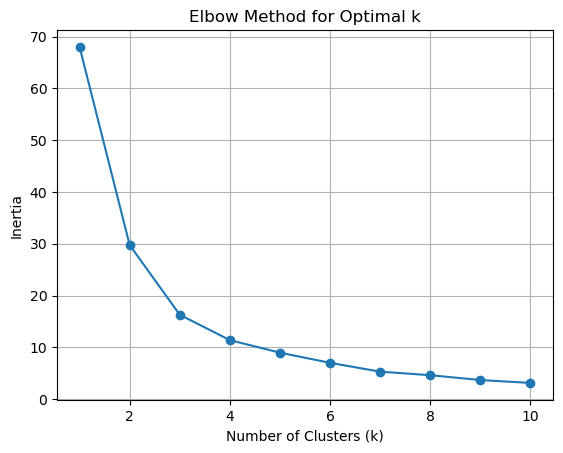

In [9]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def elbow_method(result,clustering_features):
  # eg :- clustering_features = ['speed_mean', 'speed_variance']
  X = result[clustering_features]

  # Standardize the data (important for K-Means)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Initialize lists to store inertia values for different k
  inertia_values = []

  # Determine a range of k values to test (e.g., from 1 to 10 clusters)
  k_values = range(1, 11)

  # Calculate inertia for each k value
  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
      kmeans.fit(X_scaled)
      inertia_values.append(kmeans.inertia_)

  # Plot the elbow graph
  plt.plot(k_values, inertia_values, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.grid(True)
  plt.show()

elbow_method(df, ['speed_mean', 'speed_std'])

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_features = scaler.fit_transform(df[['speed_mean', 'speed_std']])

In [11]:
# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
df['cluster'] = kmeans.fit_predict(scaled_features)


c:\Users\manda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [42]:
norms = df.groupby("cluster").mean()

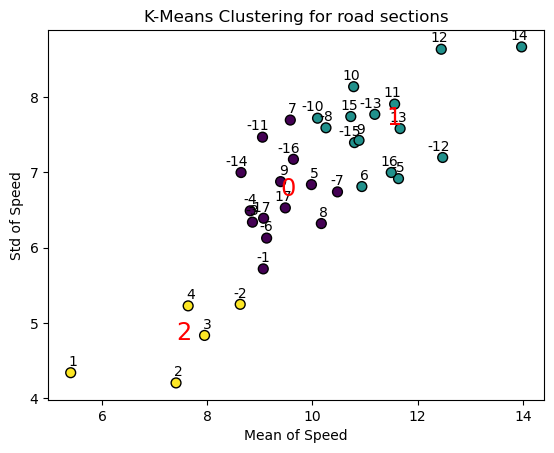

In [43]:
# Plot the clusters in the reduced space
plt.scatter(df['speed_mean'], df['speed_std'], c=df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
    
# Add labels near data points
for i, label in enumerate(df.index.to_list()):
    plt.annotate(label, (df['speed_mean'][label], df['speed_std'][label]), textcoords="offset points", xytext=(5,5), ha='right')

for i in range(len(norms)):
    plt.text(norms.loc[i]['speed_mean'],norms.loc[i]['speed_std'], i, color="red", fontsize='xx-large')

plt.title('K-Means Clustering for road sections')
plt.xlabel('Mean of Speed')
plt.ylabel('Std of Speed')
plt.show()

In [44]:
norms

,speed_mean,speed_std
cluster,,
0,9.382448,6.693555
1,11.395713,7.634967
2,7.404558,4.768115
